In [1]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 
import tensorflow_probability as tfp 
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import LambdaCallback

tfd = tfp.distributions
tfb = tfp.bijectors

color_list = ['#bcad', '#dacb']

### Define the dataset

(-2.0, 2.0)

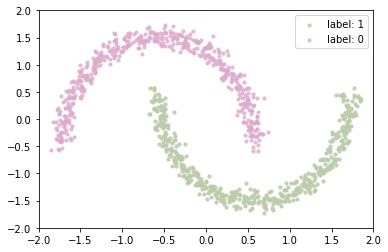

In [2]:
n_samples = 1000
niosy_moons = make_moons(n_samples=n_samples, noise=.05)
X, y = niosy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

y_label = y.astype(np.bool)
X_train, Y_train = X_data[:,0], X_data[:,1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color=color_list[0])
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color=color_list[1])
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

### Define the base distribution

In [3]:
mvn = tfd.MultivariateNormalDiag(loc=[0.,0.], scale_diag=[1.,1.])
mvn

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

### MAF initialization

In [4]:
def masked_autoregressive_flow(hidden_units=[16,16], event_shape=[2], activation='relu'):
    network = tfb.AutoregressiveNetwork(params=2, 
                                    hidden_units=hidden_units,
                                    event_shape=event_shape,
                                    activation=activation
                                   )
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=network)

### Transformed distribution

In [5]:
trainable_dist = tfd.TransformedDistribution(distribution=mvn,
                                             bijector=masked_autoregressive_flow(
                                             activation='sigmoid'))
trainable_dist

<tfp.distributions.TransformedDistribution 'masked_autoregressive_flowMultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

### Initialize samples

In [6]:
x = mvn.sample(sample_shape=(n_samples, 2))
names = [mvn.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

### Plot routine

In [7]:
def _plot(results, rows=1, legend=False, plot_color: str=color_list[0]):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(X, Y, s=10, color=plot_color)
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(names[i])
            
            i += 1

### Prior training

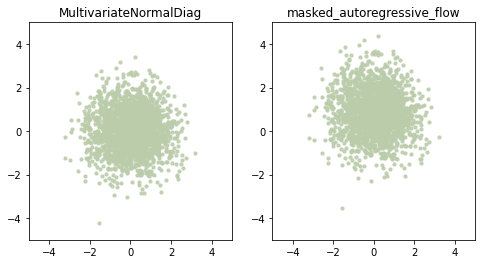

In [8]:
_plot(samples)

### Training routine

In [9]:
def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=lambda _, log_prob: -log_prob)

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )


    history = model.fit(x=X_data,
                        y=np.zeros((ns, 0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=0,
                        callbacks=[epoch_callback])
    return history

### Train the distribution

In [10]:
history = train_dist_routine(trainable_distribution=trainable_dist,
                            n_epochs=600,
                            n_disp=200)


 Epoch 1/600 
	 loss: 3.1738, val_loss: 3.1480

 Epoch 201/600 
	 loss: 2.7675, val_loss: 2.7539

 Epoch 401/600 
	 loss: 2.7167, val_loss: 2.6982


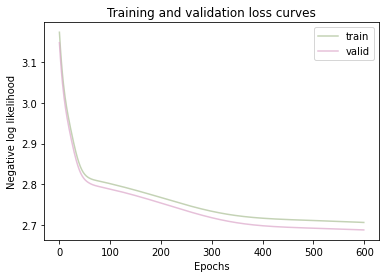

In [11]:
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.plot(train_losses, label='train', c=color_list[0])
plt.plot(valid_losses, label='valid', c=color_list[1])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

### After training -- w/o stacking & permutation & batch normalization

In [12]:
x = mvn.sample(sample_shape=(n_samples,2))
names = [mvn.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

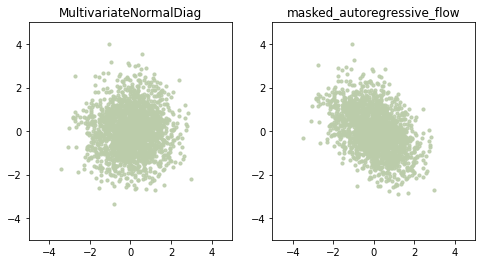

In [13]:
_plot(samples, rows=1)

### Complex model -- apply bijectors in reverse order

In [14]:
num_layers = 4
flow_bijector = []

for i in range(num_layers):
    flow_i = masked_autoregressive_flow(hidden_units=[256,256])
    flow_bijector.append(flow_i) 
    flow_bijector.append(tfb.Permute([1,0]))
# discard the last permute layer 
flow_bijector = tfb.Chain(list(reversed(flow_bijector[:-1])))

In [15]:
trainable_dist = tfd.TransformedDistribution(distribution=mvn,
                                            bijector=flow_bijector)

### Generate samples

In [16]:
def make_samples():
    x = mvn.sample((n_samples, 2))
    samples = [x]
    names = [mvn.name]
    for bijector in reversed(trainable_dist.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

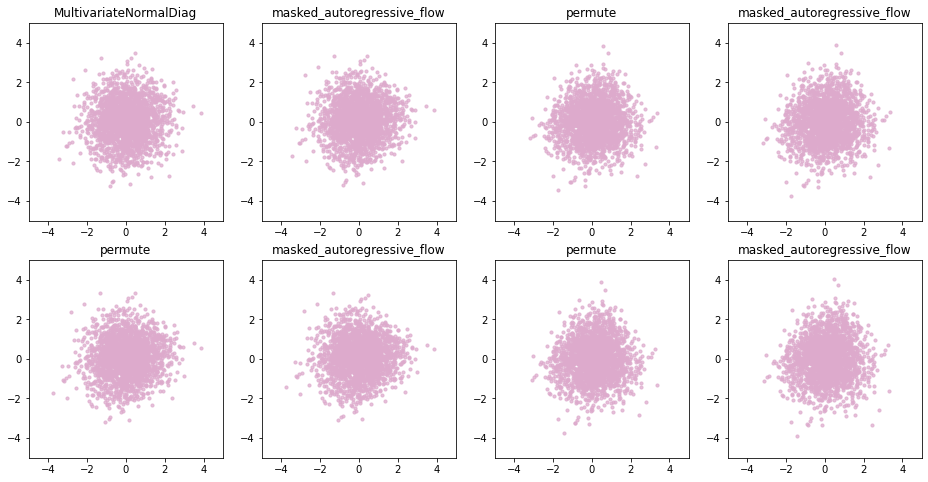

In [17]:
_plot(samples, rows=2, plot_color=color_list[1])

In [18]:
def visualize_training_data(samples, plot_color: str=color_list[0]):
    f, arr = plt.subplots(1, 2, figsize=(20,5))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color=plot_color)
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

### Visualization -- before training

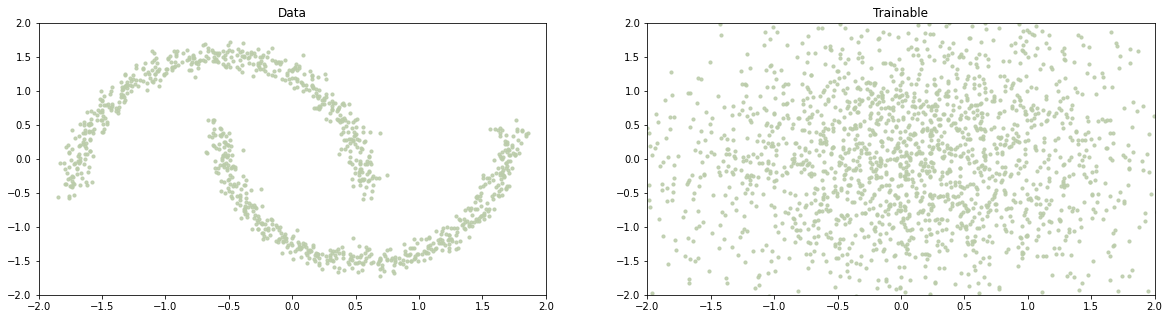

In [19]:
visualize_training_data(samples)

In [20]:
history = train_dist_routine(trainable_distribution=trainable_dist,
                            n_epochs=600,
                            n_disp=200)


 Epoch 1/600 
	 loss: 2.8733, val_loss: 2.6831

 Epoch 201/600 
	 loss: 1.7315, val_loss: 1.8152

 Epoch 401/600 
	 loss: 1.6420, val_loss: 1.6727


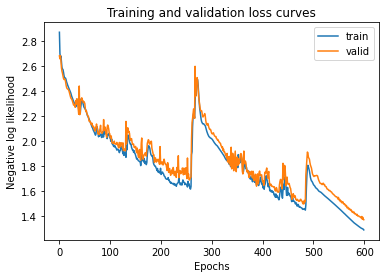

In [21]:
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [22]:
names, samples = make_samples()

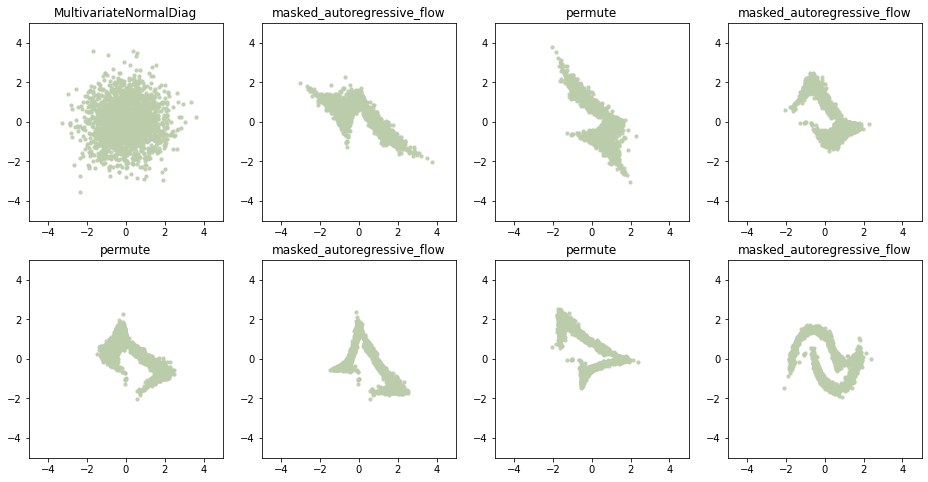

In [23]:
_plot(samples, rows=2)

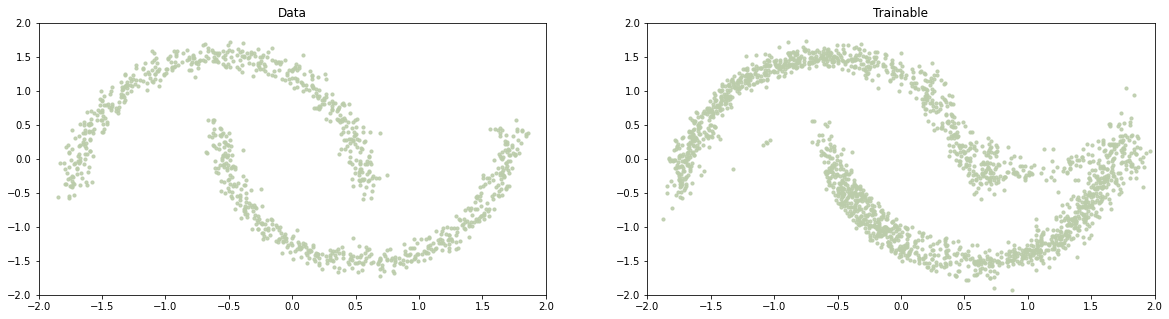

In [24]:
visualize_training_data(samples)